In [44]:
# import 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import math
import string
import pandas as pd
from scipy.stats import t 
from scipy.stats import norm
from statistics import mean
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from timeit import default_timer as timer
from functools import partial

In [4]:
# functions
# update the mean and std
def update(initial_mean, initial_std, alpha, kappa, num_encounter, m_env, var_env):
	varc1   = (alpha-1)/(alpha-0.5)       # constants in equtions for variance updating 
	varc2   = 0.5*kappa/(kappa+1)/(alpha-0.5)
	mean    = [0]*num_encounter
	std     = [0]*num_encounter
	mean[0] = initial_mean
	std[0]  = initial_std
	for nstep in range(1,num_encounter):
		x = random.gauss(m_env,math.sqrt(var_env)) #gauss(mean,std)
		mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
		std[nstep]  = math.sqrt( varc1*std[nstep-1]**2+varc2*(x-mean[nstep-1])**2 )
	return(mean,std)

# Calculate the probability of activating
def POA(alpha,kappa,m,beta,u_target,var_target):
	theta=0.01
	threshold=t.ppf(1-theta,2*alpha,m,math.sqrt((kappa+1)*beta/kappa/alpha))
	poa=1-norm.cdf(threshold,loc=u_target,scale=math.sqrt(var_target))
	return(poa)


In [67]:
# Fig1 flobal variables
num_encounter = 100 # number of encounters and number of different initial values 
alpha   = 10   # memory parameters, which determine the exponential decay of measurement weight.
kappa   = 20 
m_env   = 0   # true environment signal distributin Gaussian function N(0,4)
var_env = 4

In [68]:
# Fig 1 Code 1/2 generating evolution of mean and standard deviation
df      = pd.DataFrame()

# part 1. initial different men and same var ------------------------------------
initial_means = np.arange(-10, 11, 2)
initial_std   = 1
num_means     = len(initial_means)
for i_case in range(num_means):
	initial_mean = initial_means[i_case]
	df['mean%d'%i_case],df['std%d'%i_case] = update(initial_mean,initial_std, alpha, kappa, num_encounter, m_env, var_env)

# part 2. initial same mean and different var ------------------------------------
initial_mean = 5
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)
for i_case in range(num_means,num_means+num_stds):
	initial_std = initial_stds[i_case-num_means]
	df['mean%d'%i_case],df['std%d'%i_case] = update(initial_mean,initial_std, alpha, kappa, num_encounter, m_env, var_env)

df.to_csv ('estimated_mean_std_alpha%d.csv'%alpha, index = None, header=True) 
print('Fig 1 data done')

Fig 1 data done


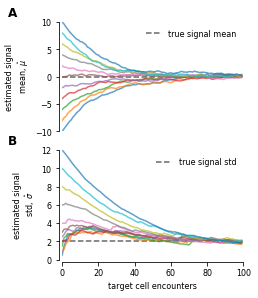

In [69]:
# Fig 1 Code 2/2 plottting
# read data
data = pd.read_csv('estimated_mean_std_alpha%d.csv'%10) 
# Plotting -----------------------------------------------
fig = plt.figure(figsize=(3.425,4))
plt.rc('font',size=8)
ax1 = fig.add_axes([0.23, 0.55, 0.735, 0.38])
ax2 = fig.add_axes([0.23, 0.105, 0.735, 0.38])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.set_xlim([0,num_encounter])
ax1.set_ylim([-10,10])
ax1.set_ylabel('estimated signal\n mean, $\hat{\mu}$',fontsize=8)
ax1.text(-0.3, 1.05, string.ascii_uppercase[0], transform=ax1.transAxes, 
		size=12, weight='bold')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.set_xlim([0,num_encounter])
ax2.set_ylim([0,12])

ax2.set_xlabel('target cell encounters',fontsize=8)
ax2.set_ylabel('estimated signal\n std, $\hat{\sigma}$',fontsize=8)
ax2.text(-0.3, 1.05, string.ascii_uppercase[1], transform=ax2.transAxes, 
		size=12, weight='bold')
ax1.axhline(0.0, color='black',linestyle='dashed',alpha=0.6,label='true signal mean')
ax2.axhline(math.sqrt(var_env), color='black',linestyle='dashed',alpha=0.6,label='true signal std')
ax1.legend(loc='upper right',frameon=False)
ax2.legend(loc='upper right',frameon=False)
# Case 1 different means and same variance ---------------
for j_mu in range(num_means):
	ax1.plot(data['mean%d'%j_mu],alpha=0.7)
# Case 2 initial same mu and different var ------------------------------------
for j_std in range(num_means,num_means+num_stds):
	ax2.plot(data['std%d'%j_std],alpha=0.7)


plt.savefig('Fig1_adapting.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

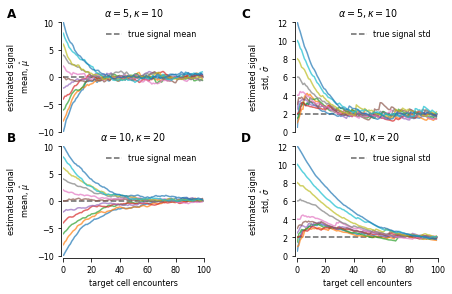

In [70]:
# SI Fig 1  different memeory 
# Case 3 compare alpha=5 vs 10----------------------------------------------------
if __name__ =='__main__':
	# Plotting -----------------------------------------------
	fig = plt.figure(figsize=(6.5,4))
	plt.rc('font',size=8)
	ax1 = fig.add_axes([0.15, 0.55, 0.3, 0.38])
	ax2 = fig.add_axes([0.15, 0.12, 0.3, 0.38])
	ax3 = fig.add_axes([0.65, 0.55, 0.3, 0.38])
	ax4 = fig.add_axes([0.65, 0.12, 0.3, 0.38])
	ax1.spines['right'].set_visible(False)
	ax1.spines['top'].set_visible(False)
	ax1.spines['bottom'].set_visible(False)
	ax1.axes.get_xaxis().set_visible(False)
	ax2.spines['right'].set_visible(False)
	ax2.spines['top'].set_visible(False)
	ax3.spines['right'].set_visible(False)
	ax3.spines['top'].set_visible(False)
	ax3.spines['bottom'].set_visible(False)
	ax3.axes.get_xaxis().set_visible(False)
	ax4.spines['right'].set_visible(False)
	ax4.spines['top'].set_visible(False)
	ax1.spines['left'].set_position(('axes', -0.02))
	ax3.spines['left'].set_position(('axes', -0.02))
	ax2.spines['bottom'].set_position(('axes', -0.02))
	ax2.spines['left'].set_position(('axes', -0.02))
	ax4.spines['bottom'].set_position(('axes', -0.02))
	ax4.spines['left'].set_position(('axes', -0.02))
	ax1.set_xlim([0,num_encounter])
	ax1.set_ylim([-10,10])
	ax2.set_xlim([0,num_encounter])
	ax2.set_ylim([-10,10])
	ax3.set_xlim([0,num_encounter])
	ax3.set_ylim([0,12])
	ax4.set_xlim([0,num_encounter])
	ax4.set_ylim([0,12])
	ax1.axhline(m_env, color='black',linestyle='dashed',alpha=0.6,label='true signal mean')
	ax1.legend(loc='upper right',frameon=False)
	ax1.set_ylabel('estimated signal\n mean, $\hat{\mu}$',fontsize=8)
	ax1.text(-0.4, 1.05, string.ascii_uppercase[0], transform=ax1.transAxes, 
            size=12, weight='bold')
	ax1.set_title(r'$\alpha=5,\kappa=10$')
	ax2.axhline(m_env, color='black',linestyle='dashed',alpha=0.6,label='true signal mean')
	ax2.legend(loc='upper right',frameon=False)
	ax2.set_xlabel('target cell encounters',fontsize=8)
	ax2.set_ylabel('estimated signal\n mean, $\hat{\mu}$',fontsize=8)
	ax2.text(-0.4, 1.05, string.ascii_uppercase[1], transform=ax2.transAxes, 
            size=12, weight='bold')
	ax2.set_title(r'$\alpha=10,\kappa=20$')
	ax3.axhline(math.sqrt(var_env), color='black',linestyle='dashed',alpha=0.6,label='true signal std')
	ax3.legend(loc='upper right',frameon=False)
	ax3.set_ylabel('estimated signal\n std, $\hat{\sigma}$',fontsize=8)
	ax3.text(-0.4, 1.05, string.ascii_uppercase[2], transform=ax3.transAxes, 
            size=12, weight='bold')
	ax3.set_title(r'$\alpha=5,\kappa=10$')
	ax4.axhline(math.sqrt(var_env), color='black',linestyle='dashed',alpha=0.6,label='true signal std')
	ax4.legend(loc='upper right',frameon=False)
	ax4.set_xlabel('target cell encounters',fontsize=8)
	ax4.set_ylabel('estimated signal\n std, $\hat{\sigma}$',fontsize=8)
	ax4.text(-0.4, 1.05, string.ascii_uppercase[3], transform=ax4.transAxes, 
            size=12, weight='bold')
	ax4.set_title(r'$\alpha=10,\kappa=20$')
	
	# different initial mu and same var ------------------------------------
	# 1 read data and Plot data --------------------------------------------------
	data_shortmem = pd.read_csv('estimated_mean_std_alpha%d.csv'%5)
	data_longmem = pd.read_csv('estimated_mean_std_alpha%d.csv'%10)
	for j_mu in range(num_means):
		ax1.plot(data_shortmem['mean%d'%j_mu],alpha=0.7)
		ax2.plot(data_longmem['mean%d'%j_mu],alpha=0.7)

	for j_std in range(num_means,num_means+num_stds):
		ax3.plot(data_shortmem['std%d'%j_std],alpha=0.7)
		ax4.plot(data_longmem['std%d'%j_std],alpha=0.7)
	plt.savefig('SI_Fig1_adapting.pdf', format='pdf', dpi=300)
	plt.show()
	plt.close()

In [71]:
# Fig2 global variables
#global variable
alpha     = 10
kappa     = 20
varc1     = (alpha-1)/(alpha-0.5)       # constants in equtions for variance updating 
varc2     = 0.5*kappa/(kappa+1)/(alpha-0.5)
m_env1    = 0
var_env1  = 1
m_env2    = 5 # mean of second environmental signal and target
var_env2  = 4
num1env   = 50
num2env   = 100
num3env   = 150
total_num = num1env+num2env+num3env

In [72]:
# Fig 2 code 1/2 data for 'Single NK cell adapt to new environment'
# mean std and probability of activating evolution
mean      = [0]*total_num
std       = [0]*total_num
poa       = [0]*total_num
beta      = [0]*total_num
mean[0]   = m_env1
std[0]    = math.sqrt(var_env1)
beta[0]   = std[0]**2*(alpha-1)
poa[0]     =(POA(alpha,kappa,mean[0],beta[0],m_env2,var_env2))

# healthy environment
for nstep in range(1,num1env):
	x = random.gauss(m_env1,math.sqrt(var_env1)) #gauss(mean,std)
	mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
	std[nstep]  = math.sqrt( varc1*std[nstep-1]**2+varc2*(x-mean[nstep-1])**2 )
	beta[nstep] = std[nstep-1]**2*(alpha-1)
	poa[nstep]   = POA(alpha,kappa,mean[nstep-1],beta[nstep],m_env2,var_env2)
# unhealthy environment
for nstep in range(num1env,num1env+num2env):
	x = random.gauss(m_env2,math.sqrt(var_env2)) #gauss(mean,std)
	mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
	std[nstep]  = math.sqrt( varc1*std[nstep-1]**2+varc2*(x-mean[nstep-1])**2 )
	beta[nstep] = std[nstep-1]**2*(alpha-1)
	poa[nstep]   = POA(alpha,kappa,mean[nstep-1],beta[nstep],m_env2,var_env2)
# healthy environment
for nstep in range(num1env+num2env,num1env+num2env+num3env):
	x = random.gauss(m_env1,math.sqrt(var_env1)) #gauss(mean,std)
	mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
	std[nstep]  = math.sqrt( varc1*std[nstep-1]**2+varc2*(x-mean[nstep-1])**2 )
	beta[nstep] = std[nstep-1]**2*(alpha-1)
	poa[nstep]   = POA(alpha,kappa,mean[nstep-1],beta[nstep],m_env2,var_env2)

# data saving ----------------------------------------------------
df = pd.DataFrame()
df['mean'] = mean
df['std']  = std
df['beta'] = beta
df['poa']  = poa
df.to_csv('MultiEnvs_mean_std_beta_poa.csv', index = None, header=True) 
print('Fig 2 data : done')

Fig 2 data : done


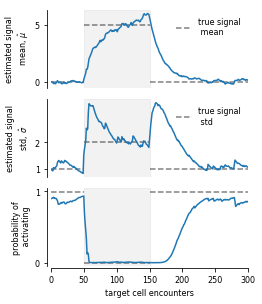

In [73]:
# Fig 2. 2/2 
# load data
data = pd.read_csv('MultiEnvs_mean_std_beta_poa.csv')

# plotting ------------------------------------------------------
fig = plt.figure(figsize=(3.425,4))
plt.rc('font', size=8)
ax1 = fig.add_axes([0.165, 0.73, 0.8, 0.27])
ax2 = fig.add_axes([0.165, 0.42, 0.8, 0.27])
ax3 = fig.add_axes([0.165, 0.11, 0.8, 0.27])
ax1.tick_params(top=False,labelbottom=False) 
ax2.tick_params(top=False,labelbottom=False) 
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax3.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
ax1.set_xlim(0,total_num)
ax2.set_xlim(0,total_num)
ax3.set_xlim(0,total_num)
ax1.set_yticks([0,5])
ax1.set_yticklabels([0,5])
ax2.set_yticks([1,2])
ax2.set_yticklabels([1,2])
ax3.set_yticks([0,1])
ax1.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey')
ax2.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey')
ax3.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey')
#plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
ax1.hlines(y=m_env1,xmin=0,xmax=num1env, color='black',linestyle='dashed',alpha=0.5,label='true signal\n mean')
ax1.hlines(y=m_env2,xmin=num1env,xmax=num1env+num2env, color='black',linestyle='dashed',alpha=0.5)
ax1.hlines(y=m_env1,xmin=num1env+num2env,xmax=num1env+num2env+num3env, color='black',linestyle='dashed',alpha=0.5)
ax2.hlines(y=math.sqrt(var_env1),xmin=0,xmax=num1env, color='black',linestyle='dashed',alpha=0.5,label='true signal\n std ')
ax2.hlines(y=math.sqrt(var_env2),xmin=num1env,xmax=num1env+num2env, color='black',linestyle='dashed',alpha=0.5)
ax2.hlines(y=math.sqrt(var_env1),xmin=num1env+num2env,xmax=num1env+num2env+num3env, color='black',linestyle='dashed',alpha=0.5)
ax3.hlines(0.99,0,num1env, color='black',linestyle='dashed',alpha=0.5)
ax3.hlines(0,num1env,num1env+num2env, color='black',linestyle='dashed',alpha=0.5)
ax3.hlines(0.99,num1env+num2env,num1env+num2env+num3env, color='black',linestyle='dashed',alpha=0.5)
#ax3.set_ylim(0,1)
#ax3.set_yticks(np.arange(0, 1.1, step=1))
# plot
ax1.legend(loc='upper right',frameon=False)
ax2.legend(loc='upper right',frameon=False)
ax1.plot(df['mean'])
ax1.set_ylabel('estimated signal\n mean, $\hat{\mu}$')
ax2.plot(df['std'])
ax2.set_ylabel('estimated signal\n std, $\hat{\sigma}$')
ax3.plot(df['poa'])
ax3.set_xlabel('target cell encounters')
ax3.set_ylabel('probability of\n activating')
plt.savefig('Fig2_NKAdaptToChangingEnv.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

In [74]:
# Fig3 global variables
#global variable
num_cell  = 500
alpha     = 10
kappa     = 20
m_env1    = 0
var_env1  = 1
m_env2    = 5 # mean of second environmental signal and target
var_env2  = 4
num1env   = 50
num2env   = 100
num3env   = 150
total_num = num1env+num2env+num3env

In [66]:
# Fig 3 1/2 data for Finite memory of past interactions with 
# target cells results in heterogeneous immune cell behaviors.
mean      = [0]*total_num
std       = [0]*total_num
poa       = [0]*total_num
beta      = [0]*total_num
mean[0]   = m_env1
std[0]    = math.sqrt(var_env1)
beta[0]   = std[0]**2*(alpha-1)
poa[0]    = (POA(alpha,kappa,mean[0],beta[0],m_env2,var_env2))
df        = pd.DataFrame()

# loop over num_cell
for i_cell in range(num_cell):
	mean[0]   = m_env1
	std[0]    = math.sqrt(var_env1)
	beta[0]   = std[0]**2*(alpha-1)
	poa[0]    =(POA(alpha,kappa,mean[0],beta[0],m_env2,var_env2))
	# healthy environment
	for nstep in range(1,num1env):
		x = random.gauss(m_env1,math.sqrt(var_env1)) #gauss(mean,std)
		mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
		std[nstep]  = math.sqrt( varc1*std[nstep-1]**2+varc2*(x-mean[nstep-1])**2 )
		beta[nstep] = std[nstep-1]**2*(alpha-1)
		poa[nstep]   = POA(alpha,kappa,mean[nstep-1],beta[nstep],m_env2,var_env2)
	# unhealthy environment
	for nstep in range(num1env,num1env+num2env):
		x = random.gauss(m_env2,math.sqrt(var_env2)) #gauss(mean,std)
		mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
		std[nstep]  = math.sqrt( varc1*std[nstep-1]**2+varc2*(x-mean[nstep-1])**2 )
		beta[nstep] = std[nstep-1]**2*(alpha-1)
		poa[nstep]   = POA(alpha,kappa,mean[nstep-1],beta[nstep],m_env2,var_env2)
	# healthy environment
	for nstep in range(num1env+num2env,num1env+num2env+num3env):
		x = random.gauss(m_env1,math.sqrt(var_env1)) #gauss(mean,std)
		mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
		std[nstep]  = math.sqrt( varc1*std[nstep-1]**2+varc2*(x-mean[nstep-1])**2 )
		beta[nstep] = std[nstep-1]**2*(alpha-1)
		poa[nstep]   = POA(alpha,kappa,mean[nstep-1],beta[nstep],m_env2,var_env2)
	# data saving ----------------------------------------------------
	df['mean%d'%i_cell] = mean
	df['std%d'%i_cell]   = std
	df['beta%d'%i_cell]  = beta
	df['poa%d'%i_cell]   = poa

df.to_csv('MultiEnvs_MultiCells_mean_std_beta_poa.csv', index = None, header=True) 
print('Fig3 data done')


Fig3 data done


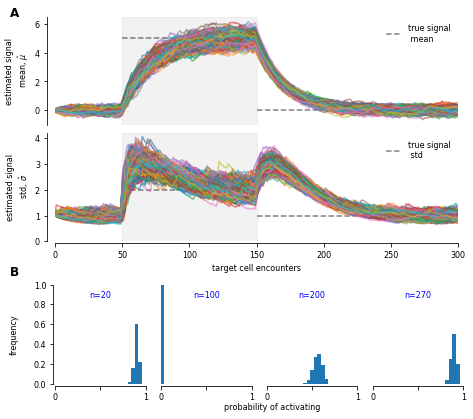

In [88]:
# Fig3 2/2 
# load data
data = pd.read_csv('MultiEnvs_MultiCells_mean_std_beta_poa.csv')

# plotting ------------------------------------------------------
fig = plt.figure(figsize=(7.0,6))
plt.rc('font', size=8)
fig.text(0.08, 0.95, string.ascii_uppercase[0],size=12, weight='bold')
fig.text(0.08, 0.35, string.ascii_uppercase[1],size=12, weight='bold')

ax1 = fig.add_axes([0.17, 0.7, 0.8, 0.25])
ax2 = fig.add_axes([0.17, 0.43, 0.8, 0.25])
ax3 = fig.add_axes([0.17, 0.1, 0.18, 0.23])
ax4 = fig.add_axes([0.38, 0.1, 0.18, 0.23])
ax5 = fig.add_axes([0.59, 0.1, 0.18, 0.23])
ax6 = fig.add_axes([0.8, 0.1, 0.18, 0.23])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))
ax1.set_ylim(-1,6.5)
ax2.set_ylim(0,4.2)
ax1.set_xlim(0,300)
ax2.set_xlim(0,300)
ax1.set_xticks([])

ax1.axvspan(50, 150, alpha=0.1, color='grey')
ax2.axvspan(50, 150, alpha=0.1, color='grey')
ax1.hlines(0,xmin=-10,xmax=num1env, color='black',linestyle='dashed',alpha=0.5,label='true signal\n mean')
ax1.hlines(5,xmin=num1env,xmax=num1env+num2env, color='black',linestyle='dashed',alpha=0.5)
ax1.hlines(0,num1env+num2env,num1env+num2env+num3env, color='black',linestyle='dashed',alpha=0.5)
ax2.hlines(y=1,xmin=-10,xmax=num1env, color='black',linestyle='dashed',alpha=0.5,label='true signal\n std')
ax2.hlines(y=2,xmin=num1env,xmax=num1env+num2env, color='black',linestyle='dashed',alpha=0.5)
ax2.hlines(1,num1env+num2env,num1env+num2env+num3env, color='black',linestyle='dashed',alpha=0.5)
ax1.legend(loc='upper right',frameon=False)
ax2.legend(loc='upper right',frameon=False)
for i_cell in range(num_cell):
	ax1.plot(data['mean%d'%i_cell],alpha=0.6)
ax1.set_ylabel('estimated signal\n mean, $\hat{\mu}$')
for i_cell in range(num_cell):
	ax2.plot(data['std%d'%i_cell],alpha=0.6)
ax2.set_ylabel('estimated signal\n std, $\hat{\sigma}$')
ax2.set_xlabel('target cell encounters')
#ax3.set_ylabel('Probability of activation (%)')
ax3.set_xticks(np.arange(0, 1.01, step=0.5))
ax4.set_xticks(np.arange(0, 1.01, step=0.5))
ax5.set_xticks(np.arange(0, 1.01, step=0.5))
ax6.set_xticks(np.arange(0, 1.01, step=0.5))
ax3.set_xticklabels(['0','','1'])
ax4.set_xticklabels(['0','','1'])
ax5.set_xticklabels(['0','','1'])
ax6.set_xticklabels(['0','','1'])
ax3.set_ylim([0,1])
ax4.set_ylim([0,1])
ax5.set_ylim([0,1])
ax6.set_ylim([0,1])
ax3.set_xlim([0,1])
ax4.set_xlim([0,1])
ax5.set_xlim([0,1])
ax6.set_xlim([0,1])
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.spines['left'].set_visible(False)
ax3.spines['left'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
ax4.spines['bottom'].set_position(('axes', -0.02))
ax5.spines['bottom'].set_position(('axes', -0.02))
ax6.spines['bottom'].set_position(('axes', -0.02))

ax3.set_ylabel('frequency\n')
ax4.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])

binstep = 0.04
bins=[]
for ibin in range(1+int(1.0/binstep)):
	bins.append(binstep*ibin)
xbins=[]
for ibin in range(int(1.0/binstep)):
	xbins.append(binstep*ibin)
#-----------------------------
poa_cols = [col for col in data.columns if 'poa' in col]
#-----------------------------
nstep = 20
pointpoas = data.loc[nstep,poa_cols]
statist=np.histogram(pointpoas,bins)[0]/num_cell
ax3.bar(xbins,height=statist,width=binstep,align='edge')
#ax3.plot(xbins,statist)
fig.text(0.26,0.3, 'n=%d'%nstep,ha='center',fontsize=8,color='b')
# ---------------------
nstep=100
pointpoas = data.loc[nstep,poa_cols]
statist=np.histogram(pointpoas,bins)[0]/num_cell
ax4.bar(xbins,height=statist,width=binstep,align='edge')
fig.text(0.47,0.3, 'n=%d'%nstep,ha='center',fontsize=8,color='b')
# ---------------------
nstep=200
pointpoas = data.loc[nstep,poa_cols]
statist=np.histogram(pointpoas,bins)[0]/num_cell
ax5.bar(xbins,height=statist,width=binstep,align='edge')
fig.text(0.68,0.3,  'n=%d'%nstep,ha='center',fontsize=8,color='b')
# ---------------------
nstep=270
pointpoas = data.loc[nstep,poa_cols]
statist=np.histogram(pointpoas,bins)[0]/num_cell
ax6.bar(xbins,height=statist,width=binstep,align='edge')
fig.text(0.89,0.3,  'n=%d'%nstep,ha='center',fontsize=8,color='b')
# ----------------------
fig.text(0.6, 0.04, 'probability of activating', ha='center')
plt.savefig('Fig3_NKsAdaptToChangingEnv.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

In [79]:
# Fig 4 global variables
u2     = 2  # data mean
sigma2 = 1 #data std
theta  = 0.01
#num    = 100
alpha  = 10
kappa  = 20
c1     = (alpha-1)/(alpha-0.5)
c2     = 0.5*(alpha-1)/(alpha-0.5)*kappa/(kappa+1) # constant in betanew = c1*beta + c2*(x-mu)**2

#gride
NX   = 101
NY   = 1001
#NX   = 11
NY   = 101
xmax = 2.5
xmin = 1.5
ymax = 15
ymin = 5
dx   = (xmax-xmin)/(NX-1)
dy   = (ymax-ymin)/(NY-1)

In [ ]:
# Fig 4 1/3 Steady state distribution of immune cell adaptation and responsiveness due to finite memory.
# dataw.txt

# Set maximum iteration
totaltime = 200
dt=0.001
NumOfTimeSteps=int(totaltime/dt)

#normalize functions
def normalize(raw):
	new = raw/np.sum(raw)/dx/dy
	return(new)

def coefficient(i,j):
	x  = xmin + dx*i
	y  = ymin + dy*j
	a1 = (u2-x)/(kappa+1)   #du=a1*dt+b1*dw dbeta=a2*dt+b2*dw
	b1 = (sigma2/(kappa+1))**2
	a2 = (c1-1)*y+c2*(u2-x)**2+c2*sigma2**2
	b2 = 2*c2**2*(sigma2**4+2*sigma2**2*(u2-x)**2)
	coef    = c2/(kappa+1)*2*(u2-x)*sigma2**2
	cow     = 1/(kappa+1) + 1 - c1 #dwdt = cow*w + codwdx*dwdx + codwdy*dwdy + codwdxx*dwdxx + codwdxy*dwdxy + codwdyy*dwdyy
	codwdx  = -a1
	codwdy  = -2*c2*sigma2**2/(kappa+1) - a2
	codwdxx = 0.5*b1
	codwdxy = coef
	codwdyy = 0.5*b2
	return(cow,codwdx,codwdy,codwdxx,codwdxy,codwdyy)
# get w and A0 ----------------------------------------------------------------
def initialize():
	# initial w
	w = np.empty(NX*NY)
	w.fill(1)
	#set boundary =0
	for ix in [0,NX-1]:
		for iy in range(NY):
			w[ix*NY+iy]=0
	for iy in [0,NY-1]:
		for ix in range(NX):
			w[ix*NY+iy]=0
	w = normalize(w)
	# calculate A0
	A0 = np.zeros((NX*NY,NX*NY))
	for ix in range(1,NX-1):
		for iy in range(1,NY-1):
			[cow,codwdx,codwdy,codwdxx,codwdxy,codwdyy]=coefficient(ix,iy)
			A0[ix*NY+iy,(ix-1)*NY+iy-1] = codwdxy/(4*dx*dy)
			A0[ix*NY+iy,(ix-1)*NY+iy+1] = -codwdxy/(4*dx*dy)
			A0[ix*NY+iy,(ix-1)*NY+iy] = -codwdx/(2*dx)+codwdxx/(dx**2)
			A0[ix*NY+iy,ix*NY+iy-1] = -codwdy/(2*dy)+codwdyy/(dy**2)
			A0[ix*NY+iy,ix*NY+iy] = cow-2*codwdxx/(dx**2)-2*codwdyy/(dy**2)
			A0[ix*NY+iy,ix*NY+iy+1] = codwdy/(2*dy)+codwdyy/(dy**2)
			A0[ix*NY+iy,(ix+1)*NY+iy-1] = -codwdxy/(4*dx*dy)
			A0[ix*NY+iy,(ix+1)*NY+iy] = codwdx/(2*dx)+codwdxx/(dx**2)
			A0[ix*NY+iy,(ix+1)*NY+iy+1] = codwdxy/(4*dx*dy)
	return(w,A0)
#------------------------------------------------------------------------
# get A in AX=b. A=I-A0/2*dt
def getA(A0):
	A=np.zeros((NX*NY,NX*NY))
	for ix in range(1,NX-1):
		for iy in range(1,NY-1):
			A[ix*NY+iy,(ix-1)*NY+iy-1] = -dt/2*A0[ix*NY+iy,(ix-1)*NY+iy-1]
			A[ix*NY+iy,(ix-1)*NY+iy+1] = -dt/2*A0[ix*NY+iy,(ix-1)*NY+iy+1]
			A[ix*NY+iy,(ix-1)*NY+iy] = -dt/2*A0[ix*NY+iy,(ix-1)*NY+iy]
			A[ix*NY+iy,ix*NY+iy-1] = -dt/2*A0[ix*NY+iy,ix*NY+iy-1]
			A[ix*NY+iy,ix*NY+iy] = -dt/2*A0[ix*NY+iy,ix*NY+iy]
			A[ix*NY+iy,ix*NY+iy+1] = -dt/2*A0[ix*NY+iy,ix*NY+iy+1]
			A[ix*NY+iy,(ix+1)*NY+iy-1] = -dt/2*A0[ix*NY+iy,(ix+1)*NY+iy-1]
			A[ix*NY+iy,(ix+1)*NY+iy] = -dt/2*A0[ix*NY+iy,(ix+1)*NY+iy]
			A[ix*NY+iy,(ix+1)*NY+iy+1] = -dt/2*A0[ix*NY+iy,(ix+1)*NY+iy+1]
	for ixa0 in range(NX*NY):
		A[ixa0,ixa0]+=1
	return(A)
#Atemp=(I+A/2*dt)
def getAtemp(A0):
	Atemp=np.zeros((NX*NY,NX*NY))
	for ix in range(1,NX-1):
		for iy in range(1,NY-1):
			Atemp[ix*NY+iy,(ix-1)*NY+iy-1] = dt/2*A0[ix*NY+iy,(ix-1)*NY+iy-1]
			Atemp[ix*NY+iy,(ix-1)*NY+iy+1] = dt/2*A0[ix*NY+iy,(ix-1)*NY+iy+1]
			Atemp[ix*NY+iy,(ix-1)*NY+iy] = dt/2*A0[ix*NY+iy,(ix-1)*NY+iy]
			Atemp[ix*NY+iy,ix*NY+iy-1] = dt/2*A0[ix*NY+iy,ix*NY+iy-1]
			Atemp[ix*NY+iy,ix*NY+iy] = dt/2*A0[ix*NY+iy,ix*NY+iy] 
			Atemp[ix*NY+iy,ix*NY+iy+1] = dt/2*A0[ix*NY+iy,ix*NY+iy+1] 
			Atemp[ix*NY+iy,(ix+1)*NY+iy-1] = dt/2*A0[ix*NY+iy,(ix+1)*NY+iy-1]
			Atemp[ix*NY+iy,(ix+1)*NY+iy] = dt/2*A0[ix*NY+iy,(ix+1)*NY+iy]
			Atemp[ix*NY+iy,(ix+1)*NY+iy+1] = dt/2*A0[ix*NY+iy,(ix+1)*NY+iy+1] 
	for ixa0 in range(NX*NY):
		Atemp[ixa0,ixa0]+=1
	return(Atemp)
#get b = Atemp*w
def getb(Atemp,w):
	b=[0]*(NX*NY)
	for ixa0 in range(NX*NY):
		b[ixa0] = np.dot(Atemp[ixa0],w)
	return(b)
#initial global constant------------------------------------------------------
[w,A0] = initialize()
A = csr_matrix(getA(A0))
Atemp=getAtemp(A0)

#data output
df = pd.DataFrame()
df['w0'] = w

#main loop------------------------------------------------
for iteration in range(1,NumOfTimeSteps):
	time0 = timer()
	b = getb(Atemp,w)
	w = spsolve(A,b)
	for i in range(len(w)):
		if w[i] < 0:
			w[i] = 0
	w = normalize(w)
	#output----------------------------------------------------
	if iteration%500==0:
		df['w%d'%iteration] = w
	print(timer()-time0)
df.to_csv('Fokker_planck_solution.csv', index = None, header=True,compression='gzip')

In [80]:
# Fig 4 2/3 Steady state distribution of immune cell adaptation and responsiveness due to finite memory.
# part 2 For each set of (\mu,\beta) calculate the probability of activating.
u2 = 4.59 # this value is where POA of the center
poa = [0]*(NX*NY)
for i in range(NX):
	for j in range(NY):
		mu = xmin+i*dx
		beta = ymin+j*dy
		poa[i*NY+j] = POA(alpha,kappa,mu,beta,u2,sigma2**2)
df = pd.DataFrame()
df['poa'] = poa
df.to_csv('poa_matrix.csv', index = None, header=True)
print('Fig 4 poa matrix : done')

Fig 4 poa matrix : done


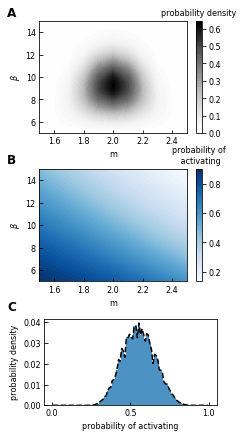

In [81]:
# Fig 4 3/3 
colorinterpolation = 50 # Set colour interpolation and colour map

def getdata():
	lookup = 't='
	t=0
	myFile = open("../../Data/dataFig4/dataw.txt","r")
	for num,line in enumerate(myFile, 0):
		if lookup in line:
			t=num
	myFile.close()
	myFile=open("../../Data/dataFig4/dataw.txt","r")
	read=myFile.readlines()
	T=read[t+1].split()
	T = [float(i) for i in T]
	T = np.array(T).reshape((NX,NY))
	time=float(read[t].split('=')[1])
	myFile.close()
	return(T,time)

[w,time]=getdata()
#dataw = pd.read_csv('./hpcc/Fokker_planck_solution.csv',compression='gzip')
#col = dataw.columns[-1]
#w=dataw[col]
#w=np.array(w).reshape((NX,NY))
data = pd.read_csv('poa_matrix.csv')
poa = np.array(data['poa']).reshape((NX,NY))
# ploting ---------------------------
fig = plt.figure(figsize=(3.42,6))
plt.rc('font', size=8)
ax1 = fig.add_axes([0.15, 0.7, 0.75, 0.26])
ax2 = fig.add_axes([0.15, 0.357, 0.75, 0.26])
ax3 = fig.add_axes([0.17, 0.07, 0.7, 0.2])
fig.text(0.02, 0.97, string.ascii_uppercase[0],
		size=12, weight='bold')
fig.text(0.02, 0.63, string.ascii_uppercase[1],
		size=12, weight='bold')
fig.text(0.02, 0.29, string.ascii_uppercase[2],
		size=12, weight='bold')
ax1.tick_params(direction='in') 
ax2.tick_params(direction='in') 
ax3.tick_params(direction='in') 
ax1.set_xlabel('m') #greek_letterz=[chr(code) for code in range(945,970)]
ax1.set_ylabel(r'$\beta$')
ax2.set_xlabel('m') #greek_letterz=[chr(code) for code in range(945,970)]
ax2.set_ylabel(r'$\beta$')
ax3.set_xlabel('probability of activating') 
ax3.set_ylabel('probability density')
#ax1.title("Contour of Probability t=%f"%((iteration+1)*dt))
X    = xmin+dx*np.arange(NX)
Y    = ymin+dy*np.arange(NY)
pos1=ax1.contourf(X, Y, w.T, colorinterpolation, cmap=plt.cm.get_cmap('Greys')) #.T means transpose because contourf treat T[i,j] as X[j] Y[i]
cbar1 = fig.colorbar(pos1, ax=ax1)
cbar1.ax.set_title('probability density',fontsize=8)
cbar1.set_ticks(np.arange(0,0.9, step=0.1))
u2 = 4.532
#ax2.title("killing potential distribution)
pos2=ax2.contourf(X, Y, poa.T, colorinterpolation, cmap=plt.cm.get_cmap('Blues'))
cbar2 = fig.colorbar(pos2, ax=ax2)
cbar2.ax.set_title('probability of\n activating',fontsize=8)
cbar2.set_ticks(np.arange(0,1, step=0.2))
#ax3.title("killing potential distribution )
binstep=0.01
bins=[]
for ibin in range(1+int(1.0/binstep)):
	bins.append(binstep*ibin)
xbin=[]
y3=[]
for ibin in range(int(1.0/binstep)):
	xbin.append((ibin+0.5)*binstep)
	y3.append(0)
for ix in range(NX):
	for iy in range(NY):
		ibin=0
		while ibin*binstep < poa[ix, iy]:
			ibin+=1
		y3[ibin]+=w[ix, iy]
y3plot = [float(i)/sum(y3) for i in y3]
ax3.plot(xbin,y3plot,color='black',linestyle='dashed')
ax3.bar(xbin,height=y3plot,width=binstep,align='center',alpha=0.8)
ax3.set_xticks(np.arange(0, 1.01, step=0.5))
plt.savefig('Fig4_DueToMemNKResponseHeterogeneous.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

In [74]:
# Fig 5 global variables
sigma2=1
size = 100000
num_encounter = 1000
c1     = (alpha-1)/(alpha-0.5)
c2     = 0.5*(alpha-1)/(alpha-0.5)*kappa/(kappa+1) # constant in betanew = c1*beta + c2*(x-mu)**2
#gride 
binstep=0.01
bins=[]
for ibin in range(1+int(1.0/binstep)):
	bins.append(binstep*ibin)
	#bins.append(binstep*ibin+0.000001)
x=[]
for ibin in range(int(1.0/binstep)):
	x.append((ibin+0.5)*binstep)

In [72]:
# 5.1 different memory length, NK cell response are heterogeneous
# read distribution of (mu,beta)
def getdata(mem_alpha):
	if mem_alpha == 5:
		filew = open('../../Data/dataFig5/alpha5.txt','r')
	elif mem_alpha == 10:
		filew = open('../../Data/dataFig5/alpha10.txt','r')
	elif mem_alpha == 20:
		filew = open('../../Data/dataFig5/alpha20.txt','r')
	elif mem_alpha == 50:
		filew = open('../../Data/dataFig5/alpha50.txt','r')
	read = filew.readlines()
	filew.close()
	data = read[-1].split()
	mu = []
	beta = []
	i = 1
	while i<len(data):
		mu.append(float(data[i]))
		beta.append(float(data[i+1]))
		i+=2
	return(mu,beta)
# x,y list for plot
def prepareXY(bins,mem_alpha,u2):
	sigma2=1
	kappa = 2*mem_alpha
	[mu,beta]=getdata(mem_alpha)
	killpotenial = []
	for imu in range(len(mu)):
		killpotenial.append(POA(mem_alpha,kappa,mu[imu],beta[imu],u2,sigma2))
	y=np.histogram(killpotenial,bins)[0]
	return(y)
#main function
if __name__ == '__main__':
	#gride 
	binstep=0.01
	bins=[]
	for ibin in range(1+int(1.0/binstep)):
		bins.append(binstep*ibin)
		#bins.append(binstep*ibin+0.000001)
	x=[]
	for ibin in range(int(1.0/binstep)):
		x.append((ibin+0.5)*binstep)
	prepareXYnew = partial(prepareXY,bins)
	#get data 
	for u2 in [6,5,4,3]:
		for mem_alpha in [5,10,20,50]:
			print(u2,mem_alpha)
			y = prepareXYnew(mem_alpha,u2)
			df['mean_%d_alpha_%d'%(u2,mem_alpha)]=y
df.to_csv('histogram_poa.csv', index = None, header=True)

6 5
6 10
6 20
6 50
5 5
5 10
5 20
5 50
4 5
4 10
4 20
4 50
3 5
3 10
3 20
3 50


In [ ]:
# Fig 5 1/3initial function------------------------------------------------------------------------------
def initial(size):
	# distribution is the initial distribution of (mu beta), size is how many point is generate
	mubeta = [0]*size
	for i in range(size):
		mubeta[i] = [random.uniform(0,5),random.uniform(0,40)]
	return(mubeta)
def update5(initial_mean, initial_beta, alpha, kappa, num_encounter, m_env, var_env):
	#mean    = [0]*num_encounter
	#beta     = [0]*num_encounter
	mean_old = initial_mean
	beta_old  = initial_beta
	for nstep in range(1,num_encounter):
		x = random.gauss(m_env,math.sqrt(var_env)) #gauss(mean,std)
		mean_new = (kappa*mean_old+x)/(kappa+1)
		beta_new = c1*beta_old+c2*(x-mean_old)**2
		mean_old,beta_old = mean_new,beta_new
	return(mean_new,beta_new)

mubeta = initial(size) #initial distribution form and number of NK cells
m_env = 2
var_env = 1
df = pd.DataFrame()
for alpha in [5,10,20,50]:
	kappa = 2*alpha
	print(alpha)
	for i_cell in range(size):
		print(i_cell,end="\r")
		mu,beta = update5(mubeta[i_cell][0],mubeta[i_cell][1], alpha, kappa, num_encounter, m_env, var_env)
		df['alpha_%d_no_%d_mu'%(alpha,i_cell)]   = mu
		df['alpha_%d_no_%d_beta'%(alpha,i_cell)] = beta
df.to_csv('diff_memory_population.csv', index = None, header=True,compression='gzip')

In [66]:
# 5.1 2/3 different memory length, NK cell response are heterogeneous
# read distribution of (mu,beta)
# load data
#data = pd.read_csv('diff_memory_population.csv',compression='gzip')
df = pd.DataFrame()
for u2 in [6,5,4,3]:
	for mem_alpha in [5,10,20,50]:
		data = pd.read_csv('./hpcc/diff_memory_population_alpha_%d.csv'%mem_alpha,compression='gzip')
		print(u2,mem_alpha)
		kappa = 2*mem_alpha
		cols_mu   = [col for col in data.columns if 'alpha_%d'%mem_alpha in col and 'mu' in col]
		cols_beta = [col for col in data.columns if 'alpha_%d'%mem_alpha in col and 'beta' in col]
		mu = data.loc[0,cols_mu]
		beta = data.loc[0,cols_beta]
		poa = [0]*len(mu)
		for imu in range(len(mu)):
			poa[imu] = POA(mem_alpha,kappa,mu[imu],beta[imu],u2,sigma2)
		y=np.histogram(poa,bins)[0]
		df['mean_%d_alpha_%d'%(u2,mem_alpha)]=y
df.to_csv('histogram_poa.csv', index = None, header=True)

6 5
6 10
6 20
6 50
5 5
5 10
5 20
5 50
4 5
4 10
4 20
4 50
3 5
3 10
3 20
3 50


step1
step2
step3
step4


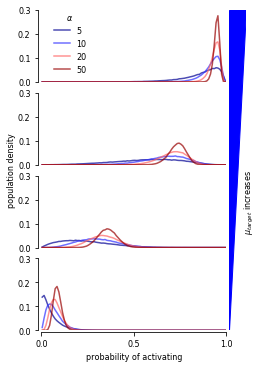

In [75]:
# Fig 5 3/3 different memory length, NK cell response are heterogeneous
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
data = pd.read_csv('histogram_poa.csv')
sigma2=1
#gride
fig = plt.figure(figsize=(3.425,5))
plt.rc('font', size=8)
fig.text(0.02, 0.6, 'population density',rotation='vertical', ha='center')
ax0 = fig.add_axes([0.9, 0.07, 0.07, 0.89])
ax1 = fig.add_axes([0.14, 0.76, 0.75, 0.2])
ax2 = fig.add_axes([0.14, 0.53, 0.75, 0.2])
ax3 = fig.add_axes([0.14, 0.30, 0.75, 0.2])
ax4 = fig.add_axes([0.14, 0.07, 0.75, 0.2])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))
ax3.spines['left'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
ax4.spines['left'].set_position(('axes', -0.02))
ax4.spines['bottom'].set_position(('axes', -0.02))


ax1.set_xlim([0,1])
ax2.set_xlim([0,1])
ax3.set_xlim([0,1])
ax4.set_xlim([0,1])
ax1.set_ylim([0,0.3])
ax2.set_ylim([0,0.3])
ax3.set_ylim([0,0.3])
ax4.set_ylim([0,0.3])
#ax1.set_yticks([])
ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks(np.arange(0, 1.01, step=0.5))
ax1.tick_params(top=False,labelbottom=False) 
ax2.tick_params(top=False,labelbottom=False) 
ax3.tick_params(top=False,labelbottom=False) 
 
ax4.set_xlabel('probability of activating')
ax0.text(0.8, 0.4, r'$\mu_{target}$ increases',
horizontalalignment='left',
verticalalignment='center',
rotation='vertical',
transform=ax0.transAxes,fontsize=8)
triangle=([(0,0),(0,1),(1,1)])
trip=matplotlib.patches.Polygon(triangle, closed=True,color='blue')
ax0.add_patch(trip)
#ax0.annotate('',xy=(0.6,0.9),xytext=(0.6,0.1),arrowprops=dict(facecolor='black', shrink=0.03,width=0.5))
ax0.axis('off')

print('step1')
u2 = 6
#cmap = plt.get_cmap('YlOrRd')
cmap = plt.get_cmap('seismic')
dicmap = {5:0.1, 10: 0.3, 20 : 0.65, 50:0.95}
for mem_alpha in [5,10,20,50]:
	y = data['mean_%d_alpha_%d'%(u2,mem_alpha)]/size
	ax1.plot(x,y,label='%d'%mem_alpha,c=cmap(dicmap[mem_alpha]),alpha=0.7)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#ax1.legend(title=r'$\alpha$',loc='EastOutside')
ax1.legend(title=r'$\alpha$',bbox_to_anchor=(0.05, 1), loc=2, borderaxespad=0,frameon=False)
print('step2')
u2 = 5
for mem_alpha in [5,10,20,50]:
	y = data['mean_%d_alpha_%d'%(u2,mem_alpha)]/size
	ax2.plot(x,y,c=cmap(dicmap[mem_alpha]),alpha=0.7)
	#ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
	ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
print('step3')
u2 = 4
for mem_alpha in [5,10,20,50]:
	y = data['mean_%d_alpha_%d'%(u2,mem_alpha)]/size
	ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
	ax3.plot(x,y,c=cmap(dicmap[mem_alpha]),alpha=0.7)
print('step4')
u2 = 3
for mem_alpha in [5,10,20,50]:
	y = data['mean_%d_alpha_%d'%(u2,mem_alpha)]/size
	ax4.plot(x,y,c=cmap(dicmap[mem_alpha]),alpha=0.7)
	ax4.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.savefig('Fif5_NKcellDiversity.pdf', format='pdf', dpi=300)
plt.show()
plt.close()